# Tanzania water pumps project : Data Analysis and cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import StandardScaler

# Import data from csv files

First, I will import the data from csv files.

In [2]:
# First, load a chunk of the data to have a look at its format
iter_df = pd.read_csv('../Data/Training Set Values.csv',chunksize=50)
test_df = next(iter_df)
test_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 40 columns):
id                       50 non-null int64
amount_tsh               50 non-null float64
date_recorded            50 non-null object
funder                   47 non-null object
gps_height               50 non-null int64
installer                47 non-null object
longitude                50 non-null float64
latitude                 50 non-null float64
wpt_name                 50 non-null object
num_private              50 non-null int64
basin                    50 non-null object
subvillage               50 non-null object
region                   50 non-null object
region_code              50 non-null int64
district_code            50 non-null int64
lga                      50 non-null object
ward                     50 non-null object
population               50 non-null int64
public_meeting           47 non-null object
recorded_by              50 non-null object
scheme_management   

From this first exploration, I can see that I can use the id as row label.
I can also parse dates for the date_recorded column.

In [4]:
X_source_df = pd.read_csv('../Data/Training Set Values.csv',index_col='id', 
                      parse_dates=['date_recorded'])
X_source_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
X_source_df.shape

(59400, 39)

In [6]:
y_source_df = pd.read_csv('../Data/Training Set Labels.csv', index_col='id')
y_source_df.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


# Exploratory Data Analysis

For exploratory data analysis, I will join the features and labels in the same dataframe.

In [7]:
source_df = X_source_df.join(y_source_df)
source_df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [8]:
source_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [9]:
source_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-

In [10]:
# prepare columns array for data cleaning
col_to_drop = []
col_to_scale = []

In [11]:
# prepare clean dataframe
clean_df = source_df.copy()

## Definition of functions used in the exploratory data analysis

In [12]:
def ttest_independence(df,col):
    """Tests if waterpoints with different opeartional status have the same distribution"""
    result_df = pd.DataFrame(index=['functional vs other', 'functional needs repair vs other',
                                    'non functional vs other'],
                             columns=['t_stat','p_value'])
    # Test functional vs other
    s_f = df[df.status_group == 'functional'][col]
    s_f_other = df[df.status_group != 'functional'][col]
    result_df.loc['functional vs other','t_stat'], result_df.loc['functional vs other','p_value'] = ttest_ind(s_f, s_f_other)
    
    # Test functional needs repair vs other
    s_fnr = df[df.status_group == 'functional needs repair'][col]
    s_fnr_other = df[df.status_group != 'functional needs repair'][col]
    result_df.loc['functional needs repair vs other','t_stat'], result_df.loc['functional needs repair vs other','p_value'] = ttest_ind(s_fnr, s_fnr_other)
    
    # Test non functional vs other
    s_nf = df[df.status_group == 'non functional'][col]
    s_nf_other = df[df.status_group != 'non functional'][col]
    result_df.loc['non functional vs other','t_stat'], result_df.loc['non functional vs other','p_value'] = ttest_ind(s_nf, s_nf_other)
    
    return result_df

In [13]:
def freq_dist_table(df,cat):
    """Returns the frequency distribution table 
    ordered by total number of waterpoints for each category"""
    # Pivot_table
    freq_dist_df = df[[cat,'status_group']]
    freq_dist_df['count_wp'] = 1
    freq_dist_df = freq_dist_df.pivot_table(index=[cat],columns=['status_group'],values=['count_wp'],aggfunc='count',fill_value=0)
    freq_dist_df.columns = freq_dist_df.columns.droplevel(0)
    freq_dist_df['nb_waterpoints'] = freq_dist_df['functional'] + freq_dist_df['functional needs repair'] + freq_dist_df['non functional']
    freq_dist_df.sort_values(by='nb_waterpoints', inplace=True)
    freq_dist_df.drop(columns='nb_waterpoints',inplace=True)
    return freq_dist_df

In [14]:
def plot_distribution(df):
    """Plots the frequency distribution"""
    plt.figure(figsize=[15,10])
    plt.bar(df.index.values, df['functional'].values, color='green')
    plt.bar(df.index.values, df['functional needs repair'].values, 
            bottom=df['functional'].values, color='orange')
    plt.bar(df.index.values, df['non functional'].values, 
            bottom=df['functional'].values+df['functional needs repair'].values, color='red')
    plt.xlabel(df.index.name)
    plt.ylabel('Number of waterpoints')
    plt.show()
    return

In [15]:
def set_less_freq(val,most_freq,other):
    """Replaces values that are not in most_freq list by other"""
    if val not in most_freq:
        return other
    else:
        return val

In [16]:
def keep_most_freq(s_in,n_to_keep,other):
    """Finds the n_to_keep most frequent values in Serie s_in
    Then, replaces all other values including NaNs by other"""
    # First, get the list of n_to_keep most frequent values
    most_freq = list(s_in.value_counts()[:n_to_keep].index)
    # Then, replace the less frequent values
    s_out = s_in.apply(set_less_freq, args=(most_freq,other))
    return s_out

In [17]:
def clean_val(s_in,map_df):
    """This function replaces the values in Serie s_in
     according to map_df.before and map_df.after"""
    s_out = s_in.copy()
    s_out = s_out.replace(to_replace=list(map_df.before), value=list(map_df.after))
    s_out = s_out.str.strip()
    s_out = s_out.str.lower()
    return s_out

In [18]:
def plot_num_vs_status(df,num):
    """Plot a violin plot for numerical feature"""
    plt.figure(figsize=[8,8])
    sns.violinplot(x=df.status_group.values, y=df[num].values, 
                   order=['functional', 'functional needs repair', 'non functional'],
                   palette=['green', 'orange', 'red'])
    plt.ylabel(num)
    plt.show()
    return

In [19]:
def plot_pie(df,col):
    """Plots 2 pie charts for a True/False column"""
    plotT_s = df[df[col] == True]['status_group'].value_counts().sort_index()
    plotF_s = df[df[col] == False]['status_group'].value_counts().sort_index()

    plt.figure(figsize=[10,5])
    plt.subplot(1,2,1)
    plt.pie(plotT_s.values,labels=plotT_s.index.values,colors=['green','orange','red'], autopct='%1.1f%%')
    plt.title(col + ' True')

    plt.subplot(1,2,2)
    plt.pie(plotF_s.values,labels=plotF_s.index.values,colors=['green','orange','red'], autopct='%1.1f%%')
    plt.title(col + ' False')

    plt.show()

## amount_tsh: Amount water available to waterpoint

In [20]:
source_df.amount_tsh.value_counts().sort_index()

0.00         41639
0.20             3
0.25             1
1.00             3
2.00            13
5.00           376
6.00           190
7.00            69
9.00             1
10.00          806
12.00            1
15.00           15
20.00         1463
25.00          356
26.00            1
30.00          743
33.00           20
35.00            8
40.00           59
50.00         2472
53.00            1
59.00            1
60.00           15
70.00           23
100.00         816
150.00          21
200.00        1220
220.00           1
250.00         569
300.00         557
             ...  
8000.00         61
8500.00          1
9000.00          3
10000.00        57
11000.00         2
12000.00        51
13000.00         2
14000.00         4
15000.00        16
16000.00         2
16300.00         2
18000.00         4
20000.00        45
25000.00         9
26000.00         2
30000.00         8
38000.00         1
40000.00         7
45000.00         3
50000.00         4
60000.00         1
70000.00    

Most of the values are 0.
The max seems huge, but there are other values above 100,000, so it's probably not an error.

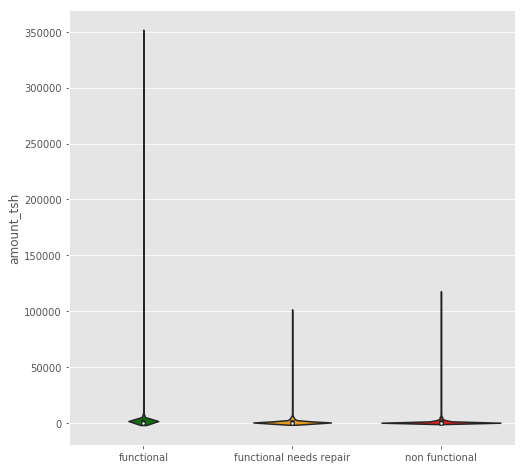

In [21]:
# Remove 0 values to have a better plot
df_in = source_df[source_df.amount_tsh!=0]
plot_num_vs_status(df_in,'amount_tsh')

The higher TSH values are all those of functional pumps.

I will test the independence of the functional waterpoints vs the others, and so on for the other operational status.

In [22]:
# Do not use 0 values to calculate chi-square
result_df = ttest_independence(df_in, 'amount_tsh')
result_df

,t_stat,p_value
functional vs other,4.76071,1.94439e-06
functional needs repair vs other,-1.05112,0.29322
non functional vs other,-4.56446,5.04147e-06


The low p_values for functional and non functional water points shows the amount_tsh for these groups is very different.
The high p_value for functional needs repair shows the amount_tsh for this group is not different from the rest of the waterpoints.

**Pre-processing:** scale the values

In [23]:
col_to_scale.append('amount_tsh')

## date_recorded: the date the row was entered

This column has no relation with the wells, so I could get rid of it. However, I may help me to fill the missing values of the construction_year column.

In [24]:
source_df[['date_recorded','construction_year']].head(10)

,date_recorded,construction_year
id,,
69572,2011-03-14,1999
8776,2013-03-06,2010
34310,2013-02-25,2009
67743,2013-01-28,1986
19728,2011-07-13,0
9944,2011-03-13,2009
19816,2012-10-01,0
54551,2012-10-09,0
53934,2012-11-03,0


A quick look shows there is no relation between date_recorded and construction_year.

**Data cleaning:** drop this column.

In [25]:
col_to_drop.append('date_recorded')

## Funder

In [26]:
source_df.funder.value_counts().sort_index().to_csv('../Data/funder.csv', header=False)
source_df.funder.value_counts()

Government Of Tanzania        9084
Danida                        3114
Hesawa                        2202
Rwssp                         1374
World Bank                    1349
Kkkt                          1287
World Vision                  1246
Unicef                        1057
Tasaf                          877
District Council               843
Dhv                            829
Private Individual             826
Dwsp                           811
0                              777
Norad                          765
Germany Republi                610
Tcrs                           602
Ministry Of Water              590
Water                          583
Dwe                            484
Netherlands                    470
Hifab                          450
Adb                            448
Lga                            442
Amref                          425
Fini Water                     393
Oxfam                          359
Wateraid                       333
Rc Church           

This column has 1897 different values, a lot of them appear only once, and there are a lot of mispelling, or same funder has different name. There is also 777 "0".
To use this column as a categorical variable, I will need to pre-process it, keeping the most frequent values and changing the less frequent as "other".
Finally, change type to category

In [27]:
def clean_funder(df,n_to_keep):
    # First clean misspellings
    funder_map = pd.read_csv('../Data/funder map.csv', header=None, names=['before','after'],index_col=False)
#    funder_map = pd.DataFrame([['0','other']],columns=['before','after'])
    s = clean_val(df.funder,funder_map)
    # Then replace less frequent with 'Other'
    s = keep_most_freq(s,n_to_keep,'other')
    # Finally, categorize
    s = s.astype('category').cat.codes
    return s

In [28]:
clean_df.funder = clean_funder(source_df,50)

In [29]:
clean_df.funder.value_counts()

30    18924
15     9123
5      3117
16     2209
40     1406
48     1349
22     1287
49     1283
44     1202
42     1057
47     1014
8       891
9       843
34      828
28      812
12      811
45      810
13      747
14      711
27      655
43      619
24      590
11      543
37      479
36      462
17      450
0       448
23      442
2       426
3       425
31      373
18      348
46      327
38      314
33      311
25      301
39      293
19      280
1       263
4       262
20      259
41      241
50      239
35      230
7       213
26      212
6       201
29      196
32      195
10      190
21      189
Name: funder, dtype: int64

Calculate the chi squared test for independence. 

In [30]:
funder_df = freq_dist_table(source_df,'funder')
chi2, p, dof, expected = chi2_contingency(funder_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 14173.222324, p_value: 0.000000


/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


p_value is 0, so we can reject the null hypothesis that the categories are independent.
The operational status is related to the funder.

## gps_height: Altitude of the well

In [31]:
source_df.gps_height.value_counts().sort_index()

-90       1
-63       2
-59       1
-57       1
-55       1
-54       1
-53       1
-52       2
-51       2
-50       5
-49       4
-48       6
-47       8
-46       6
-45       9
-44       6
-43      11
-42      13
-41      11
-40      26
-39      14
-38      17
-37      19
-36      24
-35      18
-34      18
-33      22
-32      24
-31      26
-30      26
         ..
 2469     1
 2475     1
 2484     1
 2491     1
 2501     1
 2506     1
 2509     2
 2521     1
 2523     1
 2535     1
 2536     1
 2539     1
 2545     1
 2552     1
 2554     2
 2557     1
 2559     1
 2560     2
 2566     1
 2567     1
 2568     1
 2569     1
 2576     1
 2585     1
 2614     1
 2623     1
 2626     2
 2627     1
 2628     1
 2770     1
Name: gps_height, Length: 2428, dtype: int64

Wells with negative altitudes are underground.

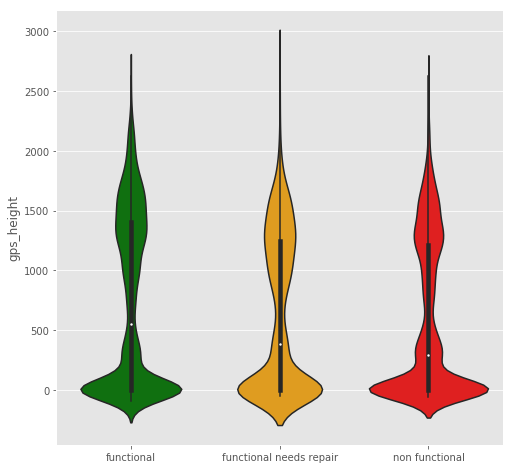

In [32]:
plot_num_vs_status(source_df,'gps_height')

The violins look very similar, like there is no relation between gps_height and operational status. Let's test their independence.

In [33]:
result_df = ttest_independence(source_df, 'gps_height')
result_df

,t_stat,p_value
functional vs other,27.7151,5.42774e-168
functional needs repair vs other,-4.00602,6.18255e-05
non functional vs other,-26.2139,1.33281e-150


The low p_values show the repartition of gps_height for these groups is very different.
So gps_height is information I should keep.

**Pre-processing:** scale this column

In [34]:
col_to_scale.append('gps_height')

## installer

In [35]:
source_df.installer.value_counts().sort_index().to_csv('../Data/installer.csv',header=False)
source_df.installer.value_counts()

DWE                               17402
Government                         1825
RWE                                1206
Commu                              1060
DANIDA                             1050
KKKT                                898
Hesawa                              840
0                                   777
TCRS                                707
Central government                  622
CES                                 610
Community                           553
DANID                               552
District Council                    551
HESAWA                              539
LGA                                 408
World vision                        408
WEDECO                              397
TASAF                               396
District council                    392
Gover                               383
AMREF                               329
TWESA                               316
WU                                  301
Dmdd                                287


This column has 2145 different values, with the same issues as the funder column.
To use this column as a categorical variable, I will need to pre-process it, keeping the most frequent values and changing the less frequent as "other"

In [36]:
def clean_installer(df, n_to_keep):
    # First, misspellings
    installer_map = pd.read_csv('../Data/installer map.csv', header=None, names=['before','after'],index_col=False)
    #installer_map = pd.DataFrame([['0','other']],columns=['before','after'])
    s = clean_val(source_df.installer,installer_map)
    # Then replace less frequent with 'Other'
    s = keep_most_freq(s,n_to_keep,'other')
    # Finally, category
    s = s.astype('category').cat.codes
    return s

In [37]:
clean_df.installer = clean_installer(source_df,50)

In [38]:
clean_df.installer.value_counts()

14    17436
31    16669
18     2669
5      1671
7      1606
19     1402
35     1307
23     1205
3      1077
10      978
48      841
16      802
40      734
34      673
4       610
39      511
43      507
2       443
26      413
46      406
30      387
12      376
45      352
42      333
32      330
41      328
6       308
49      301
0       278
1       276
36      257
13      246
21      244
22      236
38      236
20      223
33      222
37      218
11      214
44      209
8       202
24      197
29      197
15      192
25      187
27      184
9       181
28      179
47      174
17      173
Name: installer, dtype: int64

Calculate the chi squared test for independence. 

In [39]:
installer_df = freq_dist_table(source_df,'installer')
chi2, p, dof, expected = chi2_contingency(installer_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 14722.564834, p_value: 0.000000


/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


p_value is 0, so we can reject the null hypothesis that the categories are independent.
The operational status is related to the installer.

## longitude, latitude

In [40]:
source_df.latitude.value_counts().sort_index()

-1.164944e+01       1
-1.164838e+01       1
-1.158630e+01       1
-1.156858e+01       1
-1.156680e+01       1
-1.156451e+01       1
-1.156432e+01       1
-1.156232e+01       1
-1.156229e+01       1
-1.156162e+01       1
-1.156105e+01       1
-1.156055e+01       1
-1.155749e+01       1
-1.155728e+01       1
-1.155703e+01       1
-1.155639e+01       1
-1.155413e+01       1
-1.155317e+01       1
-1.153953e+01       1
-1.153842e+01       1
-1.153833e+01       1
-1.153785e+01       1
-1.153707e+01       1
-1.153679e+01       1
-1.152131e+01       1
-1.151494e+01       1
-1.151389e+01       1
-1.151323e+01       1
-1.151176e+01       1
-1.151079e+01       1
                 ... 
-1.021558e+00       1
-1.016317e+00       1
-1.015149e+00       1
-1.013978e+00       1
-1.013626e+00       1
-1.011835e+00       1
-1.010717e+00       1
-1.009458e+00       1
-1.008978e+00       1
-1.008346e+00       1
-1.007073e+00       1
-1.006552e+00       1
-1.006140e+00       1
-1.005107e+00       1
-1.004616e

In [41]:
source_df.longitude.value_counts().sort_index()

0.000000     1812
29.607122       1
29.607201       1
29.610321       1
29.610965       1
29.611947       1
29.612507       1
29.612763       1
29.613443       1
29.616872       1
29.618479       1
29.630583       1
29.638815       1
29.638904       1
29.639026       1
29.640156       1
29.640411       1
29.640963       1
29.641149       1
29.642162       1
29.642201       1
29.642269       1
29.642488       1
29.642861       1
29.643541       1
29.643546       1
29.643579       1
29.643938       1
29.644221       1
29.644315       1
             ... 
40.286679       1
40.287471       1
40.295239       1
40.298026       1
40.300378       1
40.301214       1
40.301987       1
40.301999       1
40.303795       1
40.304418       1
40.305421       1
40.305644       1
40.311031       1
40.311540       1
40.319699       1
40.320419       1
40.320693       1
40.320693       1
40.320693       1
40.320699       1
40.321966       1
40.322169       1
40.322625       1
40.322805       1
40.322832 

values equal to 0 or close to 0 are not valid.

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


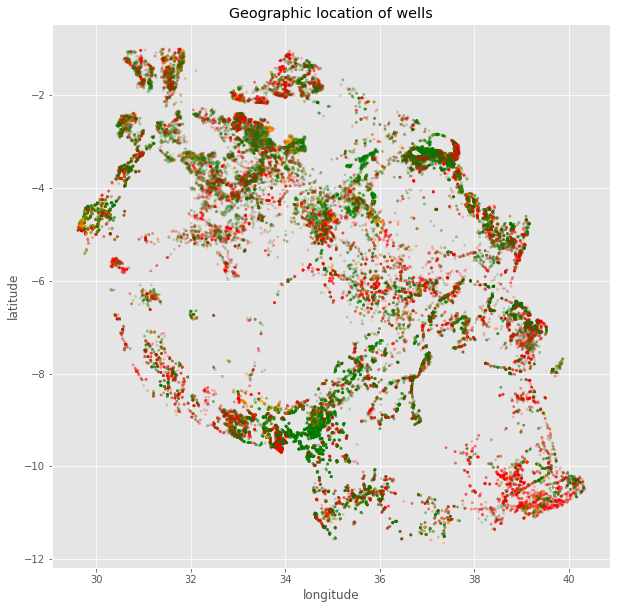

In [42]:
# plot waterpoints on a geographic map
plot_df = source_df[['latitude','longitude']]
color_dict = {'functional':'green','functional needs repair':'orange','non functional':'red'}
plot_df['colors'] = source_df.status_group.map(color_dict)

# remove invalid values before plotting
plot_df = plot_df[plot_df.latitude < -0.1]
plot_df = plot_df.loc[plot_df.longitude > 29]

plt.figure(figsize=[10,10])
plt.scatter(plot_df.longitude, plot_df.latitude, color=plot_df.colors, alpha=0.2, s=5)
#plt.scatter(mean_df.longitude, mean_df.latitude, color='blue', s=10)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Geographic location of wells')
plt.show()

There is a lot of non functional waterpoints at the south east of Tanzania.

**Data cleaning:** replace 0 or close to 0 values with the mean of the column for the same region. Tanzania is divided in 21 regions.

In [43]:
def clean_latitude_longitude(df):
    """This function replaces 0 or near 0 values by the mean of the region"""
    out_df = df.copy()
    # First, get region means
    geo_df = df[df.latitude < -0.1]
    geo_df = geo_df[geo_df.longitude > 29]
    geo_df = geo_df[['latitude','longitude','region']]
    mean_df = geo_df.groupby('region')[['latitude','longitude']].mean()
    # Then, replace near 0 values with region means
    for i in df.index:
        if i not in geo_df.index:
            region = df.loc[i,'region']
            out_df.loc[i,'latitude'] = mean_df.loc[region,'latitude']
            out_df.loc[i,'longitude'] = mean_df.loc[region,'longitude']
    return out_df.latitude, out_df.longitude

In [44]:
clean_df.latitude, clean_df.longitude = clean_latitude_longitude(source_df)

In [45]:
col_to_scale.append('latitude')
col_to_scale.append('longitude')

## wpt_name: name of the water point

In [46]:
source_df.wpt_name.value_counts()

none                    3563
Shuleni                 1748
Zahanati                 830
Msikitini                535
Kanisani                 323
Bombani                  271
Sokoni                   260
Ofisini                  254
School                   208
Shule Ya Msingi          199
Shule                    152
Sekondari                146
Muungano                 133
Mkombozi                 111
Madukani                 104
Mbugani                   94
Hospital                  94
Upendo                    93
Kituo Cha Afya            90
Mkuyuni                   88
Umoja                     84
Center                    83
Ccm                       81
Kisimani                  78
Ofisi Ya Kijiji           76
Mtakuja                   76
Tankini                   73
Bwawani                   66
Songambele                66
Maendeleo                 64
                        ... 
Kwa Ijuma                  1
Kwa Galile Mwasivila       1
Kwa Roman Massawe          1
Julius Mbwiga 

I already have the water point id, which is unique, so I can get rid of this column.

**Data cleaning:** drop this column.

In [47]:
col_to_drop.append('wpt_name')

## num_private

In [48]:
source_df.num_private.value_counts()

0       58643
6          81
1          73
5          46
8          46
32         40
45         36
15         35
39         30
93         28
3          27
7          26
2          23
65         22
47         21
102        20
4          20
17         17
80         15
20         14
25         12
11         11
41         10
34         10
16          8
120         7
150         6
22          6
12          5
24          5
        ...  
14          3
61          3
27          2
26          2
160         1
30          1
698         1
60          1
1402        1
450         1
668         1
131         1
35          1
672         1
42          1
136         1
87          1
300         1
280         1
141         1
62          1
111         1
240         1
1776        1
755         1
180         1
213         1
23          1
55          1
94          1
Name: num_private, Length: 65, dtype: int64

Most of the values are 0. I think I could get rid of this column, because there is not enough data to be useful.

**Data cleaning:** drop this column.

In [49]:
col_to_drop.append('num_private')

## basin: geographic water basin

In [50]:
source_df.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

Plot the number of waterpoints for each basin and their operational status.

In [51]:
basin_df = freq_dist_table(source_df,'basin')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


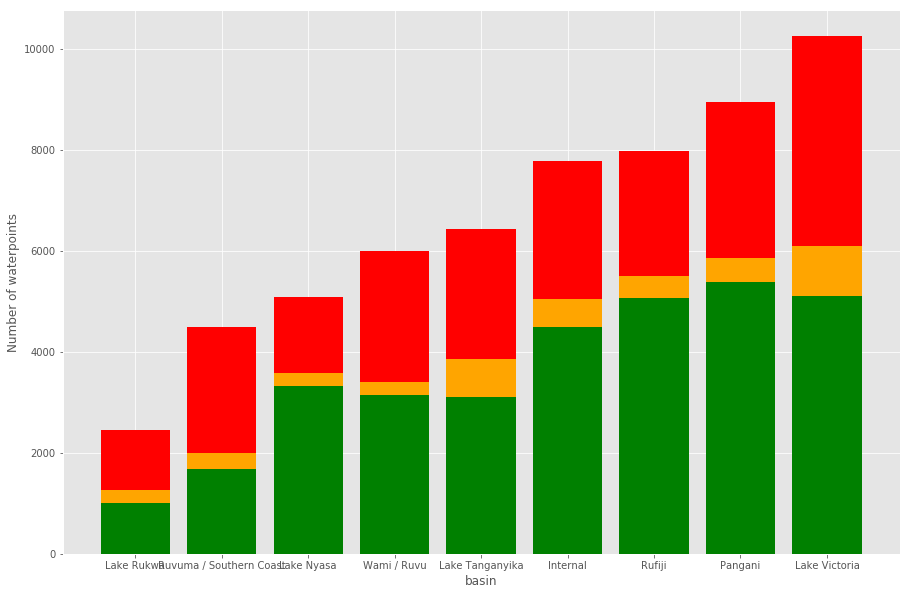

In [52]:
plot_distribution(basin_df)

Calculate the chi-square test for independence. 

In [53]:
chi2, p, dof, expected = chi2_contingency(basin_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 1921.034226, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the basin.

**Data cleaning:** change type of this column

In [54]:
clean_df.basin = source_df.basin.astype('category').cat.codes

## subvillage

In [55]:
source_df.subvillage.value_counts().sort_index().to_csv('../Data/subvillage.csv', header=False)
source_df.subvillage.value_counts()

Madukani           508
Shuleni            506
Majengo            502
Kati               373
Mtakuja            262
Sokoni             232
M                  187
Muungano           172
Mbuyuni            164
Mlimani            152
Songambele         147
Miembeni           134
Msikitini          134
1                  132
Kibaoni            114
Kanisani           111
I                  109
Mapinduzi          109
Mjimwema           108
Mjini              108
Mkwajuni           104
Mwenge             102
Azimio              98
Mabatini            98
Mbugani             95
Mission             95
Bwawani             91
Bondeni             90
Chang'Ombe          88
Zahanati            86
                  ... 
Kiteo                1
Igogolo              1
Loomunyi             1
Msewa                1
Mpujini              1
Nyamikingo           1
Mwamalumbi           1
Mburi 'A'            1
Kongoro              1
Kisagwa              1
Mwalilo              1
Kaza Mwendo          1
Nkwamembi  

This column is very messy, with a lot of values referring only to one waterpoint. I suggest to drop this column. 

**Data cleaning:** drop this column.

In [56]:
col_to_drop.append('subvillage')

## region

In [57]:
source_df.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

Plot the frequency distribution for each region.

In [58]:
region_df = freq_dist_table(source_df,'region')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


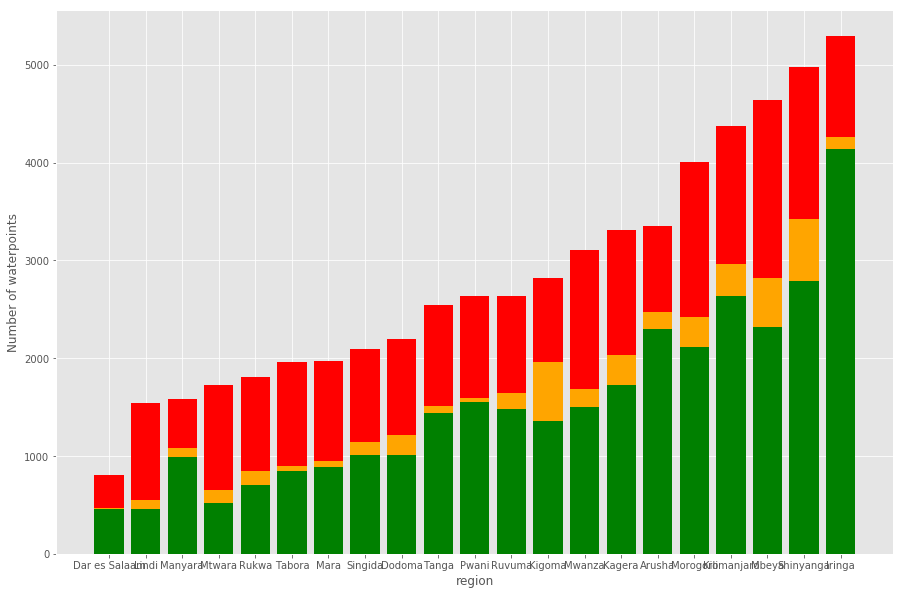

In [59]:
plot_distribution(region_df)

Calculate the chi-square test for independence. 

In [60]:
chi2, p, dof, expected = chi2_contingency(region_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 4794.631126, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the region.

**Data cleaning:** change type of this column

In [61]:
clean_df.region = source_df.region.astype('category').cat.codes

## region_code

Check the relation between region code and region

In [62]:
region_df = source_df[['region','region_code']]
region_df['count_wp'] = 1
region_df.groupby(['region', 'region_code']).count()

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


count_wp
region        region_code          
Arusha        2                3024
              24                326
Dar es Salaam 7                 805
Dodoma        1                2201
Iringa        11               5294
Kagera        18               3316
Kigoma        16               2816
Kilimanjaro   3                4379
Lindi         8                 300
              18                  8
              80               1238
Manyara       21               1583
Mara          20               1969
Mbeya         12               4639
Morogoro      5                4006
Mtwara        9                 390
              90                917
              99                423
Mwanza        17                 55
              19               3047
Pwani         6                1609
              40                  1
              60               1025
Rukwa         15               1808
Ruvuma        10               2640
Shinyanga     11                  6
              14                 20
              17               4956
Singida       13               2093
Tabora        14               1959
Tanga         4                2513
              5                  34

**Data cleaning: **
Some region have several region_code, and some region_code are shared between different region.
I will keep the region column and get rid of the region_code column, because I think it's easier to enter a wrong number than a wrong region name.

In [63]:
col_to_drop.append('region_code')

## district_code

In [64]:
source_df.district_code.value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

Calculate the chi-square test for independence. 

In [65]:
district_df = freq_dist_table(source_df,'district_code')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [66]:
chi2, p, dof, expected = chi2_contingency(district_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 1673.521277, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the district.

**Data cleaning: ** This is another geographical value. It's a numerical value, but it's a actually a categorical value. I will categorize it.

In [67]:
clean_df.district_code = source_df.district_code.astype('category').cat.codes

## lga: Geographic location

In [68]:
source_df.lga.value_counts()

Njombe              2503
Arusha Rural        1252
Moshi Rural         1251
Bariadi             1177
Rungwe              1106
Kilosa              1094
Kasulu              1047
Mbozi               1034
Meru                1009
Bagamoyo             997
Singida Rural        995
Kilombero            959
Same                 877
Kibondo              874
Kyela                859
Kahama               836
Kigoma Rural         824
Magu                 824
Maswa                809
Karagwe              771
Mbinga               750
Iringa Rural         728
Serengeti            716
Namtumbo             694
Lushoto              694
Songea Rural         693
Mpanda               679
Mvomero              671
Ngara                669
Ulanga               665
                    ... 
Ileje                231
Bahi                 224
Kisarawe             223
Temeke               215
Rorya                210
Tarime               209
Ngorongoro           201
Kiteto               193
Shinyanga Urban      191


Calculate the chi-square test for independence. 

In [69]:
lga_df = freq_dist_table(source_df,'lga')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
chi2, p, dof, expected = chi2_contingency(lga_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 11529.910639, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the lga.

**Data cleaning:** categorize this column.

In [71]:
clean_df.lga = source_df.lga.astype('category').cat.codes

## ward: geographic location

In [72]:
source_df.ward.value_counts().sort_index().to_csv('../Data/ward.csv', header=False)
source_df.ward.value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
Kitunda             203
Mishamo             203
Msindo              201
Chalinze            196
Maji ya Chai        190
Usuka               187
Ngarenanyuki        172
Chanika             171
Vikindu             162
Mtwango             153
Matola              145
Zinga/Ikerege       141
Maramba             139
Wanging'ombe        139
Itete               137
Magomeni            135
Kikatiti            134
Ifakara             134
Olkokola            133
Maposeni            130
Igongolo            129
Mvomero             129
Mlangali            125
Nkoma               122
Mahongole           121
                   ... 
Mkumbi                1
Matarawe              1
Uwanja wa Ndege       1
Ukata                 1
Kinungu               1
Mwanga Kaskazini      1
Igogo                 1
Linda                 1
Thawi                 1
Mawenzi               1
Izia            

**Data cleaning: **This can be used as a categorical data, but first, I need to group the less frequent values.

In [73]:
def clean_ward(df,n_to_keep):
    s = df.ward
    s = keep_most_freq(s,n_to_keep,'other')
    s = s.astype('category').cat.codes
    return s

In [74]:
clean_df.ward = clean_ward(source_df,50)

Calculate the chi-square test for independence. 

In [75]:
ward_df = freq_dist_table(source_df,'ward')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
chi2, p, dof, expected = chi2_contingency(ward_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 26144.961185, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the ward.

## population: Population around the well

In [77]:
source_df.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [78]:
source_df.population.value_counts().sort_index()[:1]

0    21381
Name: population, dtype: int64

There is a lot of 0 in this column, it's a lot of missing data.

In [79]:
source_df.population.value_counts().sort_index()[-10:]

8500     1
8600     1
8848     1
9000     3
9500     1
9865     1
10000    3
11463    1
15300    1
30500    1
Name: population, dtype: int64

The maximum value seems very large compared to the others, but it may be a big waterpoint serving a big city.

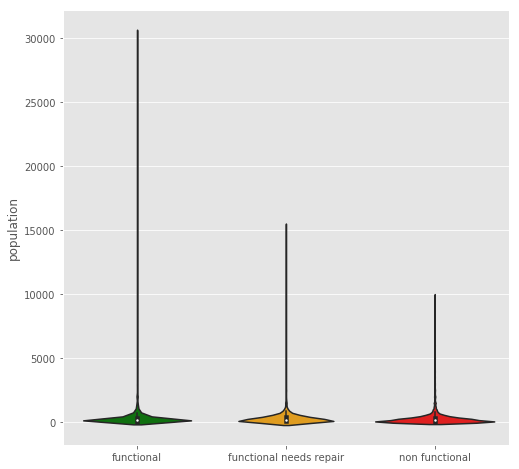

In [80]:
# First, remove 0 values to have a better plot
df_in = source_df[source_df.population!=0]
plot_num_vs_status(df_in,'population')

I will test the independence of the functional waterpoints vs the others, and so on for the other operational status.

In [81]:
result_df = ttest_independence(df_in, 'population')
result_df

,t_stat,p_value
functional vs other,2.7702,0.00560495
functional needs repair vs other,1.50508,0.132312
non functional vs other,-3.61082,0.00030562


The low p_values for functional and non functional water points shows the population for these groups is very different.
The high p_value for functional needs repair shows the population for this group is not different from the rest of the waterpoints. It means it will be more difficult to predict this category accurately.

**Data cleaning: ** Replace 0 with the median of the values because median is less sensitive to extreme values.

In [82]:
def clean_population(df):
    pop_median = df[df.population !=0].population.median()
    s = df.population.replace(to_replace=0,value=pop_median)
    return s

In [83]:
clean_df.population = clean_population(source_df)

In [84]:
col_to_scale.append('population')

## public_meeting

In [85]:
source_df.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

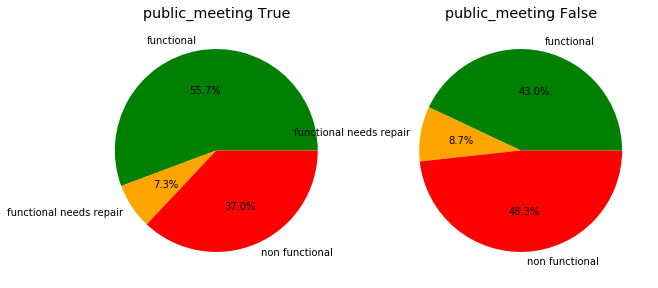

In [86]:
plot_pie(source_df,'public_meeting')

**Data cleaning: **There are NaN values. I will replace them with False.

In [87]:
def clean_public_meeting(df):
    s = df.public_meeting.fillna(False)
    return s

In [88]:
clean_df.public_meeting = clean_public_meeting(source_df)

## recorded_by

In [89]:
source_df.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

**Data cleaning: **This column has only one value, so I can remove it.

In [90]:
col_to_drop.append('recorded_by')

## scheme_management: who operates the waterpoint

In [91]:
source_df.scheme_management.value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

There are NaN and None values, and this column is redundant with management, so I will drop it.

In [92]:
col_to_drop.append('scheme_management')

## scheme_name: who operates the waterpoint

In [93]:
source_df.scheme_name.value_counts().sort_index().to_csv('../Data/scheme_name.csv', header=False)
source_df.scheme_name.value_counts()

K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
I                                          229
Bagamoyo wate                              229
Uroki-Bomang'ombe water sup                209
N                                          204
Kirua kahe gravity water supply trust      193
Machumba estate pipe line                  185
Makwale water supplied sche                166
Kijiji                                     161
S                                          154
Handeni Trunk Main(H                       152
Losaa-Kia water supply                     152
mtwango water

**Data cleaning: **This column has half of the values missing, and is very messy. I will drop it.

In [94]:
col_to_drop.append('scheme_name')

## permit: if the waterpoint is permitted

In [95]:
source_df.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

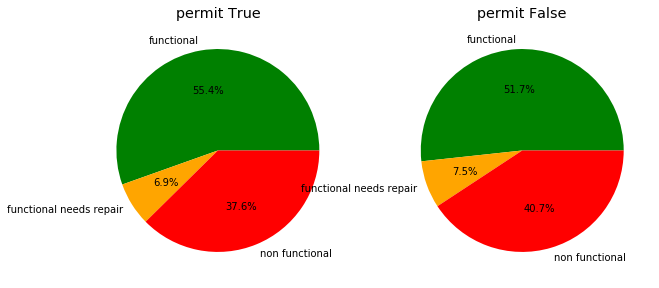

In [96]:
plot_pie(source_df,'permit')

**Data cleaning: **I will fill the NaN values with False

In [97]:
def clean_permit(df):
    s = df.permit.fillna(False)
    return s

In [98]:
clean_df.permit = clean_permit(source_df)

The proportions are very close , so I will calculate the chi-square test for independence. 

In [99]:
permit_df = freq_dist_table(source_df,'permit')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [100]:
chi2, p, dof, expected = chi2_contingency(permit_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 67.790141, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
Permit and operational status are related.

## construction_year

In [101]:
source_df.construction_year.describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

In [102]:
source_df.construction_year.value_counts()[:1]

0    20709
Name: construction_year, dtype: int64

**Data cleaning: **There is a lot of missing data in this column. I will replace the 0 with the mean

In [103]:
def clean_construction_year(df):
    year_mean = df[df.construction_year !=0].construction_year.mean()
    print('Year mean = ',year_mean)
    s = df.construction_year.replace(to_replace=0,value=year_mean)
    return s

In [104]:
clean_df.construction_year = clean_construction_year(source_df)

Year mean =  1996.8146855857951


In [105]:
col_to_scale.append('construction_year')

Plot the frequency distribution for each construction_year

In [106]:
# Remove 0 values to have a better plot
plot_df = source_df[source_df.construction_year != 0]
construction_year_df = freq_dist_table(plot_df,'construction_year')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


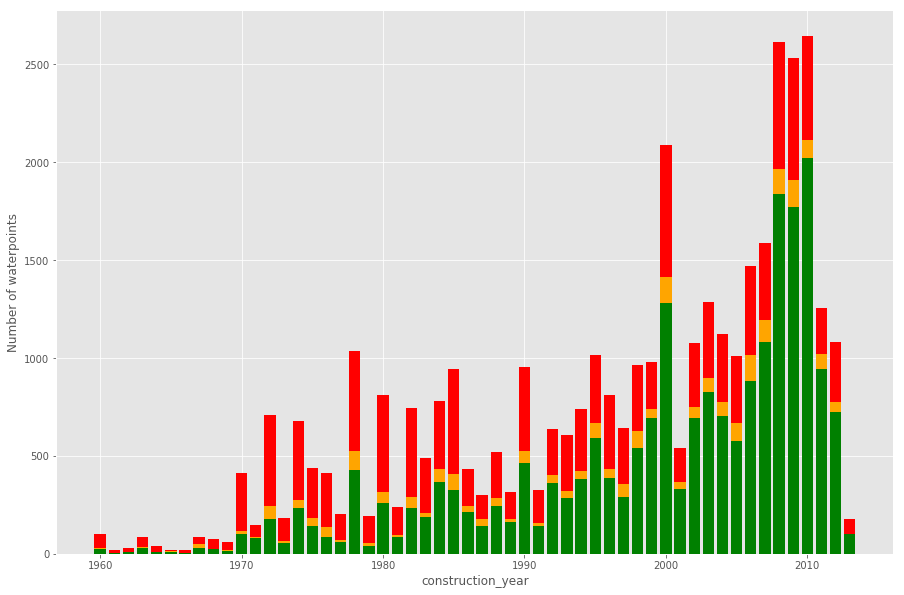

In [107]:
plot_distribution(construction_year_df)

It seems older waterpoints are more likely to be non functional.

I will test the independence of the functional waterpoints vs the others, and so on for the other operational status.

In [108]:
# First, remove 0 values
df_in = source_df[source_df.construction_year!=0]
result_df = ttest_independence(df_in, 'construction_year')
result_df

,t_stat,p_value
functional vs other,58.0668,0
functional needs repair vs other,-6.49502,8.40291e-11
non functional vs other,-55.9463,0


The low p_values show the construction year for these groups is very different.
This feature will be useful to predict the operational status.

## extraction_type, extraction_type_group, extraction_type_class

In [109]:
source_df.extraction_type.value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [110]:
source_df.extraction_type_group.value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [111]:
source_df.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

**Data cleaning: **These are categorical values. They are subgroups of one another, so they are redundant. I will keep the extraction_type_class, categorize it, and drop the other columns.

In [112]:
col_to_drop.append('extraction_type_group')
col_to_drop.append('extraction_type')
clean_df.extraction_type_class = source_df.extraction_type_class.astype('category').cat.codes

In [113]:
extraction_type_class_df = freq_dist_table(source_df,'extraction_type_class')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


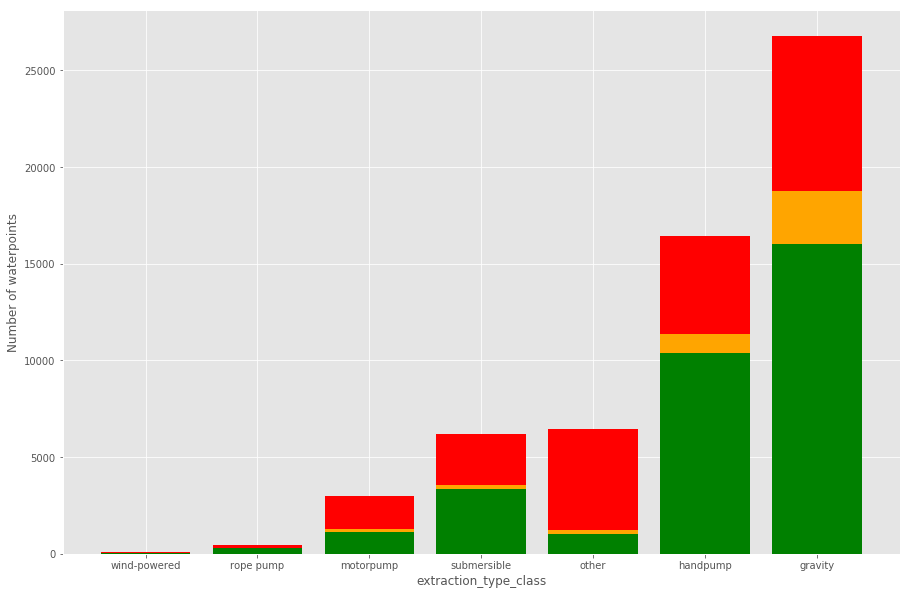

In [114]:
plot_distribution(extraction_type_class_df)

Calculate the chi-square test for independence. 

In [115]:
chi2, p, dof, expected = chi2_contingency(extraction_type_class_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 6931.201641, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status and the extraction type class are related.

## management, management_group

In [116]:
source_df.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [117]:
source_df.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

**Data cleaning: **These are categorical values. One is the sub group of the other, so they are redundant. I will keep the management, group 'unknown' and 'other', categorize, and drop the management_group.
Group categories unknown and other.

In [118]:
def clean_management(df):
    s = df.management.replace(to_replace='unknown',value='other')
    s = s.astype('category').cat.codes
    return s

In [119]:
col_to_drop.append('management_group')
clean_df.management = clean_management(source_df)

In [120]:
management_df = freq_dist_table(source_df,'management')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


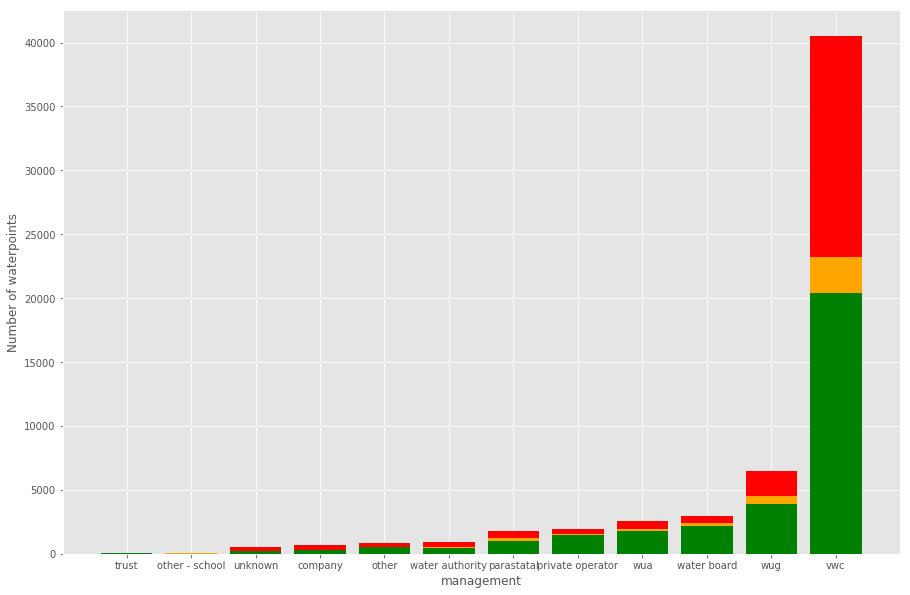

In [121]:
plot_distribution(management_df)

Calculate the chi-square test for independence. 

In [122]:
chi2, p, dof, expected = chi2_contingency(management_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 2081.126398, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status and the management are related.

## payment, payment_type

In [123]:
source_df.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [124]:
source_df.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

**Data cleaning: **These columns are identical, I can drop one of them. Group unknown and other values.

In [125]:
def clean_payment(df):
    s = df.payment.replace(to_replace='unknown', value='other')
    s = s.astype('category').cat.codes
    return s

In [126]:
col_to_drop.append('payment_type')
clean_df.payment = clean_payment(source_df)

In [127]:
payment_df = freq_dist_table(source_df,'payment')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


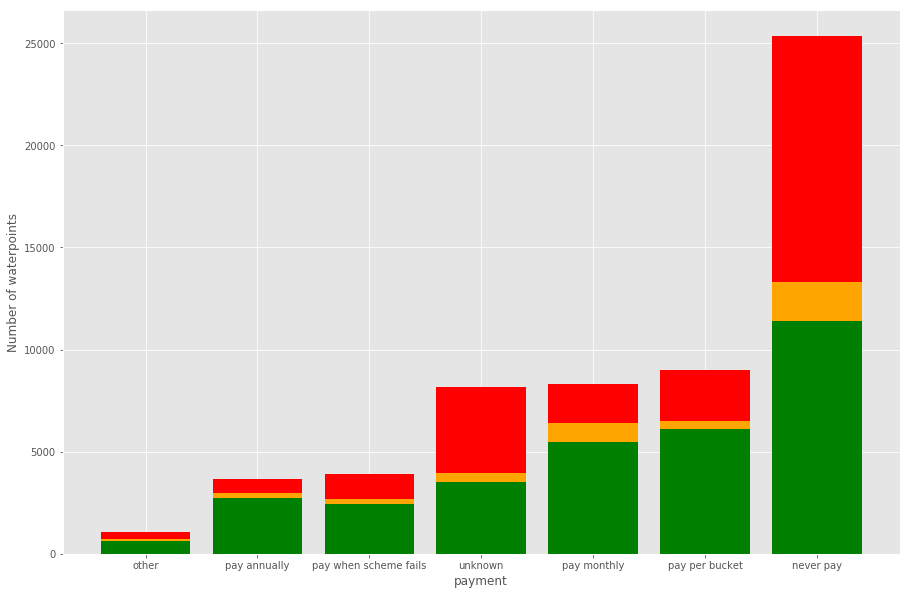

In [128]:
plot_distribution(payment_df)

It seems that when there is payment for the water (either periodically, per bucket or on failure) the waterpoint is more likely to be functional.

Calculate the chi-square test for independence. 

In [129]:
chi2, p, dof, expected = chi2_contingency(payment_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 3965.619404, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the payment.

## water_quality, quality_group

In [130]:
source_df.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [131]:
source_df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

**Data cleaning: **These are categorical values. One is the sub group of the other, so they are redundant.I will keep the quality_group, categorize it, and drop the water_quality.

In [132]:
col_to_drop.append('water_quality')
quality_group_type = pd.CategoricalDtype(categories=['unknown','fluoride','salty','colored',
                                                     'milky','good'], ordered=True)
clean_df.quality_group = source_df.quality_group.astype(quality_group_type).cat.codes

In [133]:
quality_group_df = freq_dist_table(source_df,'quality_group')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


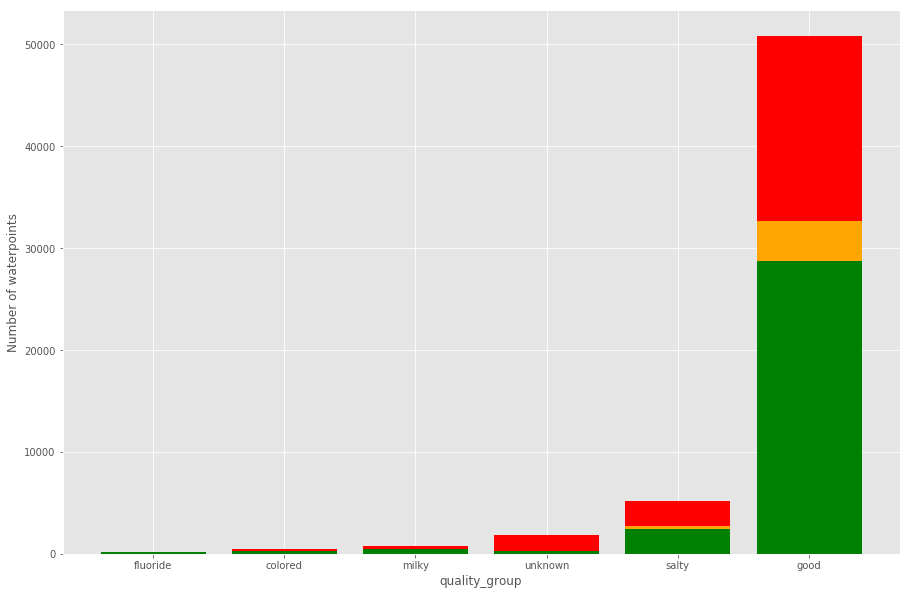

In [134]:
plot_distribution(quality_group_df)

Calculate the chi-square test for independence. 

In [135]:
chi2, p, dof, expected = chi2_contingency(quality_group_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 2100.136588, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the water quality group.

## quantity, quantity_group

In [136]:
source_df.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [137]:
source_df.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

**Data cleaning: **These columns are identical, I can drop one of them.

In [138]:
col_to_drop.append('quantity_group')
quantity_type = pd.CategoricalDtype(categories=['unknown','dry','insufficient','seasonal',
                                                'enough'], ordered=True)
clean_df.quantity = source_df.quantity.astype(quantity_type).cat.codes

In [139]:
quantity_df = freq_dist_table(source_df,'quantity')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


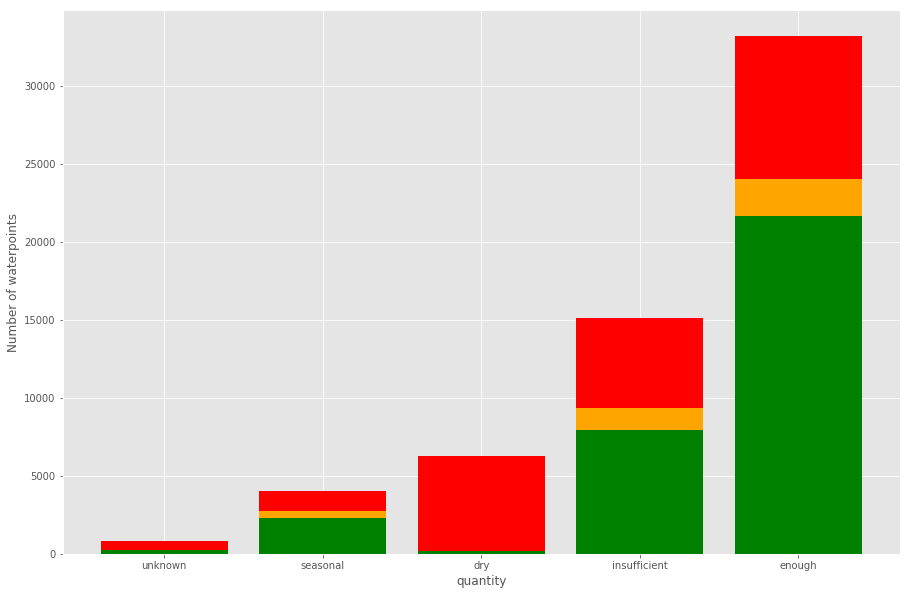

In [140]:
plot_distribution(quantity_df)

Unsurprisingly, the waterpoint is much more likely to be non functional when the quantity is dry.

Calculate the chi-square test for independence. 

In [141]:
chi2, p, dof, expected = chi2_contingency(quantity_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 11360.767896, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the water quantity group.

## source, source_type, source_class

In [142]:
source_df.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [143]:
source_df.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [144]:
source_df.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

**Data cleaning: **These are categorical values. They are subgroups of one another, so they are redundant. I will keep source_type, categorize it and drop the other columns.

In [145]:
col_to_drop.append('source')
col_to_drop.append('source_class')
clean_df.source_type = source_df.source_type.astype('category').cat.codes

In [146]:
source_type_df = freq_dist_table(source_df,'source_type')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


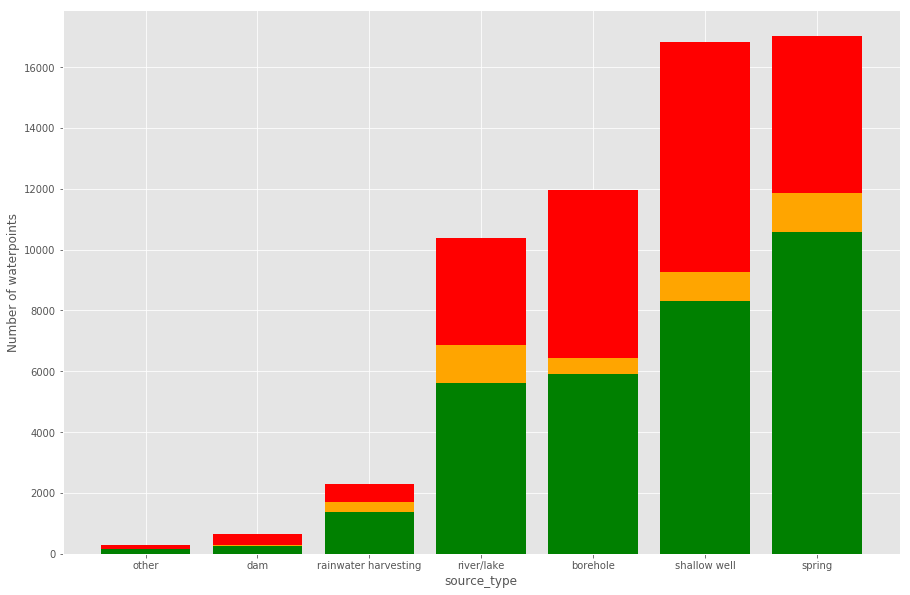

In [147]:
plot_distribution(source_type_df)

Shallow wells and boreholes are more likely to be non functional.

Calculate the chi-square test for independence. 

In [148]:
chi2, p, dof, expected = chi2_contingency(source_type_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 1906.797414, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The chi-square shows relation with the operational status.

## waterpoint_type, waterpoint_type_group

In [149]:
source_df.waterpoint_type.value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [150]:
source_df.waterpoint_type_group.value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

**Data cleaning: **These columns are redundant, with communal standpipe being divided into 2 categories in the waterpoint_type column. I can drop one of them.
I keep waterpoint_type_group, categorize it, and drop waterpoint_type.

In [151]:
col_to_drop.append('waterpoint_type')
clean_df.waterpoint_type_group = source_df.waterpoint_type_group.astype('category').cat.codes

In [152]:
waterpoint_type_group_df = freq_dist_table(source_df,'waterpoint_type_group')

/Users/tisonbertrand/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


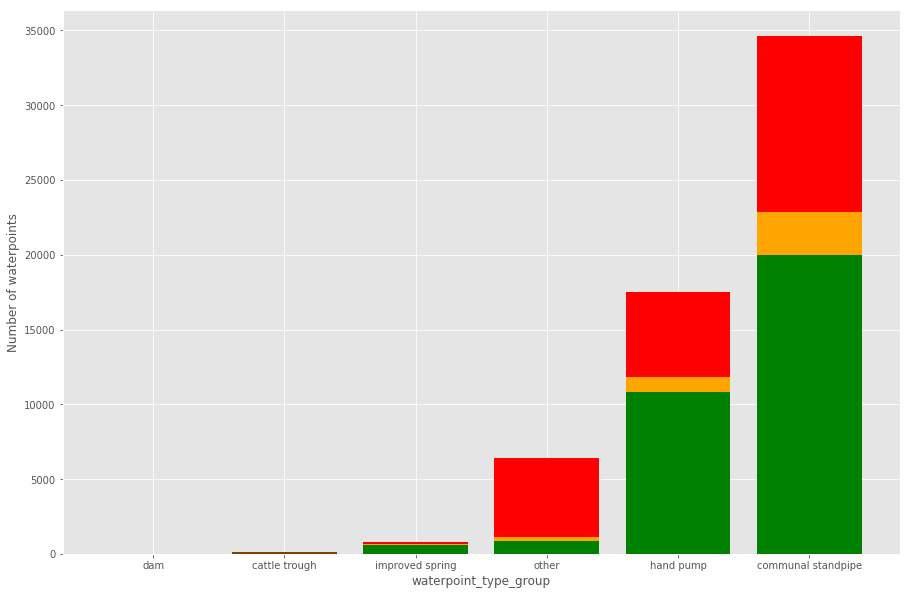

In [153]:
plot_distribution(waterpoint_type_group_df)

Calculate the chi-square test for independence. 

In [154]:
chi2, p, dof, expected = chi2_contingency(waterpoint_type_group_df.values)
print("chi2: {:f}, p_value: {:f}".format(chi2,p))

chi2: 6114.774218, p_value: 0.000000


p_value is less than 0.05, so we can reject the null hypothesis.
The operational status is related to the waterpoint type group.

## status_group

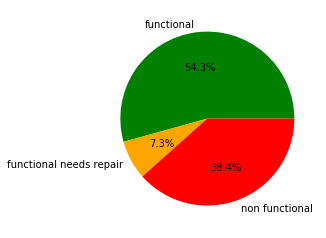

In [155]:
plot_s = source_df.status_group.value_counts().sort_index()
plt.pie(plot_s.values,labels=plot_s.index.values,colors=['green','orange','red'], autopct='%1.1f%%')
plt.show()

In [156]:
plot_s

functional                 32259
functional needs repair     4317
non functional             22824
Name: status_group, dtype: int64

The labels are not balanced, there is very few functional needs repair.
This means accuracy is not a good metric, and we should use another metric like log loss to evaluate the model.

In [157]:
status_group_type = pd.CategoricalDtype(categories=['non functional','functional needs repair',
                                                    'functional'], ordered=True)
clean_df.status_group = source_df.status_group.astype(status_group_type).cat.codes

## Finish cleaning, scale and check dataframe

In [158]:
# Drop columns
clean_df.drop(columns=col_to_drop,inplace=True)

In [159]:
# Scale columns
s = StandardScaler()
scaled_array = s.fit_transform(clean_df[col_to_scale].astype(float))
scaled_df = pd.DataFrame(scaled_array, index=clean_df.index, columns=col_to_scale)

clean_df.drop(columns=col_to_scale, inplace=True)
clean_df = pd.concat([clean_df, scaled_df], axis='columns')

In [160]:
clean_df.head()

,funder,installer,basin,region,district_code,lga,ward,public_meeting,permit,extraction_type_class,...,quantity,source_type,waterpoint_type_group,status_group,amount_tsh,gps_height,latitude,longitude,population,construction_year
id,,,,,,,,,,,,,,,,,,,,,
69572,37,34,1,3,5,51,50,True,False,0,...,4,6,1,2,1.895665,1.041252,-1.443930,-0.058426,-0.273835,0.217105
8776,30,31,4,9,2,103,50,False,True,0,...,2,3,1,2,-0.105970,1.054237,1.300721,-0.150839,0.101064,1.309926
34310,30,48,5,8,4,108,50,True,True,0,...,4,1,1,2,-0.097630,0.025541,0.704761,0.915636,0.035292,1.210578
67743,44,42,7,12,17,87,50,True,True,5,...,1,0,1,0,-0.105970,-0.584751,-1.906416,1.311620,-0.385647,-1.074410
19728,30,31,4,4,1,26,50,True,True,0,...,3,3,1,2,-0.105970,-0.964200,1.415403,-1.528549,-0.183947,0.000000


In [161]:
clean_df.describe()

,funder,installer,basin,region,district_code,lga,ward,extraction_type_class,management,payment,...,quantity,source_type,waterpoint_type_group,status_group,amount_tsh,gps_height,latitude,longitude,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,...,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04,5.940000e+04
mean,25.328283,22.117980,4.077172,9.835606,3.867424,60.039882,46.834310,1.264663,6.329630,1.631397,...,3.053838,3.970556,2.056212,1.158838,5.364466e-16,1.731275e-16,-1.474129e-17,-1.824739e-15,-8.206950e-16,1.200951e-15
std,12.457092,11.366086,2.473082,5.936892,2.992263,35.244499,9.869179,1.626676,1.917857,1.750428,...,1.162179,2.191798,1.378937,0.949794,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.059700e-01,-1.094050e+00,-2.082350e+00,-2.116918e+00,-5.106136e-01,-3.657441e+00
25%,15.000000,14.000000,2.000000,4.000000,2.000000,30.000000,50.000000,0.000000,6.000000,0.000000,...,2.000000,3.000000,1.000000,0.000000,-1.059700e-01,-9.642001e-01,-9.754900e-01,-7.164003e-01,-2.935667e-01,-8.093684e-02
50%,30.000000,18.000000,4.000000,10.000000,3.000000,60.000000,50.000000,1.000000,6.000000,1.000000,...,4.000000,5.000000,1.000000,2.000000,-1.059700e-01,-4.318175e-01,2.774190e-01,-6.975843e-02,-1.839471e-01,0.000000e+00
75%,30.000000,31.000000,6.000000,15.000000,5.000000,91.000000,50.000000,2.000000,6.000000,3.000000,...,4.000000,6.000000,3.000000,2.000000,-9.929791e-02,9.391760e-01,8.698735e-01,8.066379e-01,-4.144151e-02,7.138418e-01
max,50.000000,49.000000,8.000000,20.000000,19.000000,124.000000,50.000000,6.000000,10.000000,5.000000,...,4.000000,6.000000,5.000000,2.000000,1.166561e+02,3.032277e+00,1.709810e+00,2.029463e+00,6.635518e+01,1.607968e+00


In [162]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 23 columns):
funder                   59400 non-null int8
installer                59400 non-null int8
basin                    59400 non-null int8
region                   59400 non-null int8
district_code            59400 non-null int8
lga                      59400 non-null int8
ward                     59400 non-null int8
public_meeting           59400 non-null bool
permit                   59400 non-null bool
extraction_type_class    59400 non-null int8
management               59400 non-null int8
payment                  59400 non-null int8
quality_group            59400 non-null int8
quantity                 59400 non-null int8
source_type              59400 non-null int8
waterpoint_type_group    59400 non-null int8
status_group             59400 non-null int8
amount_tsh               59400 non-null float64
gps_height               59400 non-null float64
latitude                 5

## Save dataframe to csv file

In [163]:
clean_df.to_csv('../Data/Clean_DF.csv')